In [1]:
import sys
import os

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from features.get_merged_dataframes import get_merged_dataframes

In [2]:
pair_1, pair_2 = "BTC_USDT", "ADA_USDT" # ['ADA_USDT', 'AVAX_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'DOGE_USDT', 
         #'DOT_USDT', 'ETH_USDT', 'HBAR_USDT', 'LINK_USDT', 'LTC_USDT', 'SHIB_USDT', 
         #'SOL_USDT', 'SUI_USDT', 'TON_USDT', 'TRX_USDT', 'XLM_USDT', 'XRP_USDT']

In [3]:
train_df, val_df, test_df = get_merged_dataframes(pair_1, pair_2)

start: 2020-08-18 23:00:00+00:00, end: 2025-04-09 17:54:00+00:00


In [50]:
val_df.iloc[0].date

Timestamp('2024-01-01 11:17:00+0000', tz='UTC')

Добавим колонку target - это close_y для следующей свечи

In [20]:
df = train_df.copy()

In [21]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [22]:
df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)

df.dropna(inplace=True)

features = [col for col in df.columns if col not in ['target', 'date']]
X = df[features]
y = df['target']

train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [28]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=500,
    verbose=100
)

0:	learn: 0.5392523	test: 0.5412415	best: 0.5412415 (0)	total: 109ms	remaining: 1m 48s
100:	learn: 0.5427872	test: 0.5412111	best: 0.5412415 (0)	total: 9.57s	remaining: 1m 25s
200:	learn: 0.5452773	test: 0.5411959	best: 0.5412415 (0)	total: 18.7s	remaining: 1m 14s
300:	learn: 0.5476837	test: 0.5412719	best: 0.5412821 (296)	total: 27.3s	remaining: 1m 3s
400:	learn: 0.5492305	test: 0.5412922	best: 0.5413480 (361)	total: 36s	remaining: 53.7s
500:	learn: 0.5504667	test: 0.5413226	best: 0.5413581 (482)	total: 44.9s	remaining: 44.7s
600:	learn: 0.5513897	test: 0.5413176	best: 0.5413581 (482)	total: 53.8s	remaining: 35.7s
700:	learn: 0.5523267	test: 0.5413632	best: 0.5413886 (687)	total: 1m 2s	remaining: 26.7s
800:	learn: 0.5532079	test: 0.5413886	best: 0.5414342 (744)	total: 1m 11s	remaining: 17.8s
900:	learn: 0.5540041	test: 0.5413429	best: 0.5414342 (744)	total: 1m 20s	remaining: 8.9s
999:	learn: 0.5549005	test: 0.5413429	best: 0.5414342 (744)	total: 1m 29s	remaining: 0us

bestTest = 0.541

In [29]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.5414342225377827

Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70    106716
           1       0.56      0.00      0.00     90464

    accuracy                           0.54    197180
   macro avg       0.55      0.50      0.35    197180
weighted avg       0.55      0.54      0.38    197180



In [30]:
print("Доля предсказанных 1:", y_pred.sum() / len(y_pred), ", длина выборки", len(y_pred))

Доля предсказанных 1: 0.001967745207424688 , длина выборки 197180


In [31]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
# from sklearn.utils import class_weight


# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# train_pool = Pool(X_train, y_train)
# test_pool = Pool(X_test, y_test)
# classes = np.unique(y_train)
# weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)

# class_weights = [weights[int(c)] for c in classes]
# print('Computed class weights:', class_weights)

# model = CatBoostClassifier(
#     iterations=1000,             # Increase number of iterations for gradual learning
#     learning_rate=0.01,          # Lower learning rate to improve convergence
#     depth=6,
#     loss_function='Logloss',
#     eval_metric='AUC',           # Use AUC to focus on discrimination between classes
#     random_seed=42,
#     verbose=100,
#     od_type='Iter',
#     od_wait=100,                 # Increased patience to avoid premature stopping
#     class_weights=class_weights  # Apply the balanced class weights
# )

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=100,
#     verbose=100
# )

# y_pred_proba = model.predict_proba(X_test)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# print('Test AUC: {:.4f}'.format(roc_auc))

# j_scores = tpr - fpr
# optimal_idx = np.argmax(j_scores)
# optimal_threshold = thresholds[optimal_idx]
# print("Optimal Threshold:", optimal_threshold)

# y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# accuracy = accuracy_score(y_test, y_pred_adjusted)
# print("Adjusted Test Accuracy:", accuracy)
# print("\nClassification Report (Adjusted Threshold):")
# print(classification_report(y_test, y_pred_adjusted))

Computed class weights: [0.9319382739389356, 1.0787864032520147]
0:	test: 0.5080866	best: 0.5080866 (0)	total: 120ms	remaining: 2m
100:	test: 0.5194238	best: 0.5194325 (98)	total: 10.6s	remaining: 1m 34s
200:	test: 0.5205055	best: 0.5205697 (186)	total: 21s	remaining: 1m 23s
300:	test: 0.5209426	best: 0.5209886 (289)	total: 30.8s	remaining: 1m 11s
400:	test: 0.5215528	best: 0.5215528 (400)	total: 40.5s	remaining: 1m
500:	test: 0.5218470	best: 0.5218492 (497)	total: 50.5s	remaining: 50.3s
600:	test: 0.5218834	best: 0.5219262 (597)	total: 1m	remaining: 40.3s
700:	test: 0.5220487	best: 0.5221130 (678)	total: 1m 10s	remaining: 30.1s
800:	test: 0.5222789	best: 0.5222789 (800)	total: 1m 20s	remaining: 20.1s
900:	test: 0.5224100	best: 0.5224394 (848)	total: 1m 30s	remaining: 9.96s
999:	test: 0.5225259	best: 0.5225402 (990)	total: 1m 40s	remaining: 0us

bestTest = 0.5225402309
bestIteration = 990

Shrink model to first 991 iterations.
Test AUC: 0.5225
Optimal Threshold: 0.3881003761846366
Adju

Computed class weights: [0.9319382739389356, 1.0787864032520147]
0:	test: 0.5099170	best: 0.5099170 (0)	total: 159ms	remaining: 15m 51s
250:	test: 0.5201214	best: 0.5201462 (244)	total: 33.3s	remaining: 12m 43s
500:	test: 0.5210611	best: 0.5210611 (500)	total: 1m 4s	remaining: 11m 47s
750:	test: 0.5214354	best: 0.5214354 (750)	total: 1m 34s	remaining: 10m 58s
1000:	test: 0.5219586	best: 0.5219607 (996)	total: 2m 3s	remaining: 10m 16s
1250:	test: 0.5221912	best: 0.5222428 (1225)	total: 2m 33s	remaining: 9m 41s
1500:	test: 0.5225333	best: 0.5225333 (1500)	total: 3m 3s	remaining: 9m 10s
1750:	test: 0.5227857	best: 0.5227893 (1725)	total: 3m 34s	remaining: 8m 39s
2000:	test: 0.5230733	best: 0.5230851 (1988)	total: 4m 4s	remaining: 8m 8s
2250:	test: 0.5232682	best: 0.5232707 (2239)	total: 4m 34s	remaining: 7m 36s
2500:	test: 0.5233917	best: 0.5233966 (2487)	total: 5m 3s	remaining: 7m 4s
2750:	test: 0.5235776	best: 0.5235900 (2736)	total: 5m 32s	remaining: 6m 32s
3000:	test: 0.5238279	best: 

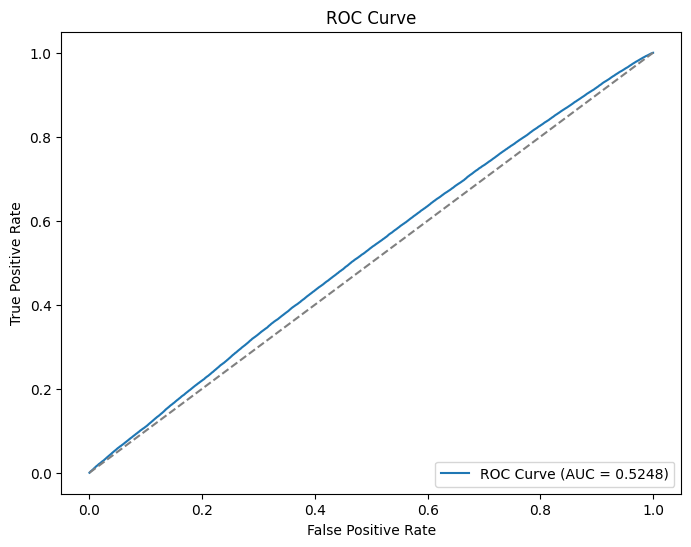

Optimal Threshold: 0.37991863770483675
Adjusted Test Accuracy: 0.5192210163302566

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.56      0.53      0.54    106716
           1       0.48      0.51      0.49     90464

    accuracy                           0.52    197180
   macro avg       0.52      0.52      0.52    197180
weighted avg       0.52      0.52      0.52    197180


Top 20 Feature Importances:
               feature  importance
88    OSC_STOCH_K_ST_y    5.717832
5    RAW_prev_return_x    4.884339
70   RAW_prev_return_y    4.436397
23    OSC_STOCH_K_ST_x    4.393277
121       VOL_ADL_ST_y    3.516178
122       VOL_ADL_MT_y    3.107336
123       VOL_ADL_LT_y    2.969111
127     TREND_CCI_ST_y    2.321481
69            volume_y    2.223307
91    OSC_STOCH_K_MT_y    1.659588
89    OSC_STOCH_D_ST_y    1.629300
79        OSC_RSI_ST_y    1.356072
26    OSC_STOCH_K_MT_x    1.218377
14        OSC_RSI_ST_x    1

In [34]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# train_pool = Pool(X_train, y_train)
# test_pool = Pool(X_test, y_test)

# classes = np.unique(y_train)
# weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)

# class_weights = [weights[int(c)] for c in classes]
# print('Computed class weights:', class_weights)

# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.005,
#     depth=8,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=300,
#     od_type='Iter',
#     od_wait=300,
#     class_weights=class_weights
# )

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=150,
#     verbose=250
# )

# y_pred_proba = model.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# print('Test AUC: {:.4f}'.format(roc_auc))

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# j_scores = tpr - fpr
# optimal_idx = np.argmax(j_scores)
# optimal_threshold = thresholds[optimal_idx]
# print("Optimal Threshold:", optimal_threshold)

# y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# accuracy = accuracy_score(y_test, y_pred_adjusted)
# print("Adjusted Test Accuracy:", accuracy)
# print("\nClassification Report (Adjusted Threshold):")
# print(classification_report(y_test, y_pred_adjusted))

# feature_importances = model.get_feature_importance(train_pool)
# feat_imp_df = pd.DataFrame({
#     'feature': X_train.columns, 
#     'importance': feature_importances
# }).sort_values(by='importance', ascending=False)

# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

Computed class weights: [0.9319382739389356, 1.0787864032520147]
0:	test: 0.5099170	best: 0.5099170 (0)	total: 147ms	remaining: 14m 39s
250:	test: 0.5203307	best: 0.5203308 (242)	total: 32.4s	remaining: 12m 22s
500:	test: 0.5214980	best: 0.5215351 (496)	total: 1m 2s	remaining: 11m 26s
750:	test: 0.5219926	best: 0.5220778 (707)	total: 1m 33s	remaining: 10m 53s
1000:	test: 0.5224511	best: 0.5224511 (1000)	total: 2m 3s	remaining: 10m 16s
1250:	test: 0.5231607	best: 0.5231607 (1250)	total: 2m 33s	remaining: 9m 43s
1500:	test: 0.5234622	best: 0.5234967 (1443)	total: 3m 4s	remaining: 9m 11s
1750:	test: 0.5238234	best: 0.5238274 (1736)	total: 3m 33s	remaining: 8m 38s
2000:	test: 0.5240635	best: 0.5240938 (1992)	total: 4m 1s	remaining: 8m 3s
2250:	test: 0.5244205	best: 0.5244352 (2233)	total: 4m 29s	remaining: 7m 29s
2500:	test: 0.5246101	best: 0.5246196 (2492)	total: 4m 58s	remaining: 6m 57s
2750:	test: 0.5248201	best: 0.5248436 (2723)	total: 5m 27s	remaining: 6m 26s
3000:	test: 0.5251185	bes

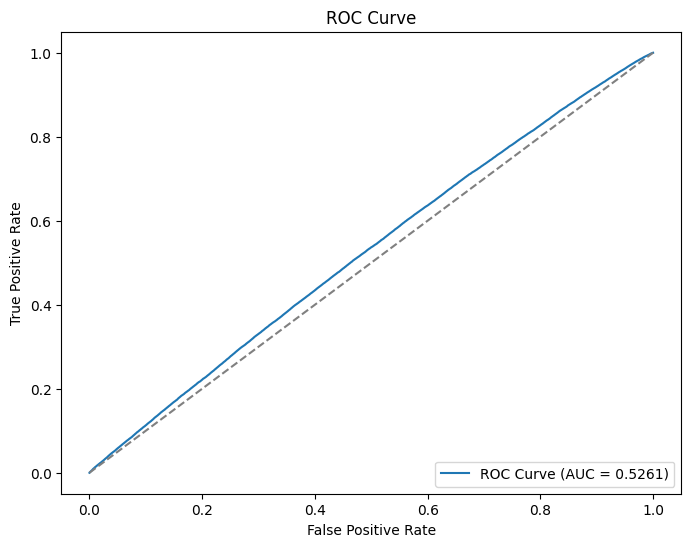

Optimal Threshold: 0.3572003793962005
Adjusted Test Accuracy: 0.5122121919058729

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.56      0.44      0.49    106716
           1       0.48      0.60      0.53     90464

    accuracy                           0.51    197180
   macro avg       0.52      0.52      0.51    197180
weighted avg       0.52      0.51      0.51    197180


Top 20 Feature Importances:
                feature  importance
88     OSC_STOCH_K_ST_y    4.089856
5     RAW_prev_return_x    3.927369
70    RAW_prev_return_y    3.587558
23     OSC_STOCH_K_ST_x    3.574008
127      TREND_CCI_ST_y    2.355852
69             volume_y    2.142151
121        VOL_ADL_ST_y    2.036313
123        VOL_ADL_LT_y    2.010020
122        VOL_ADL_MT_y    1.722412
89     OSC_STOCH_D_ST_y    1.686550
62       TREND_CCI_ST_x    1.524336
91     OSC_STOCH_K_MT_y    1.468396
4              volume_x    1.382768
33         OSC

In [35]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
df.dropna(inplace=True)

features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)

class_weights = [weights[int(c)] for c in classes]
print('Computed class weights:', class_weights)

model = CatBoostClassifier(
    iterations=6000,
    learning_rate=0.008,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=250,
    od_type='Iter',
    od_wait=300,
    class_weights=class_weights
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=200,
    verbose=250
)

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print('Test AUC: {:.4f}'.format(roc_auc))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_adjusted)
print("Adjusted Test Accuracy:", accuracy)
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))

In [36]:
model.save_model("zero_fees_classification_model_DOT_baseline_1.cbm")

In [ ]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# train_pool = Pool(X_train, y_train)
# test_pool = Pool(X_test, y_test)

# classes = np.unique(y_train)
# weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)

# class_weights = [weights[int(c)] for c in classes]
# print('Computed class weights:', class_weights)

# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.008,
#     depth=8,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=250,
#     od_type='Iter',
#     od_wait=300,
#     class_weights=class_weights
# )

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=200,
#     verbose=250
# )

# y_pred_proba = model.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# print('Test AUC: {:.4f}'.format(roc_auc))

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# j_scores = tpr - fpr
# optimal_idx = np.argmax(j_scores)
# optimal_threshold = thresholds[optimal_idx]
# print("Optimal Threshold:", optimal_threshold)

# y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# accuracy = accuracy_score(y_test, y_pred_adjusted)
# print("Adjusted Test Accuracy:", accuracy)
# print("\nClassification Report (Adjusted Threshold):")
# print(classification_report(y_test, y_pred_adjusted))

# feature_importances = model.get_feature_importance(train_pool)
# feat_imp_df = pd.DataFrame({
#     'feature': X_train.columns, 
#     'importance': feature_importances
# }).sort_values(by='importance', ascending=False)

# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

0:	learn: 0.9999953	test: 0.9991709	best: 0.9991709 (0)	total: 146ms	remaining: 14m 33s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 1
bestIteration = 2

Shrink model to first 3 iterations.
Threshold for recall ≥ 0.85: 0.5023
Precision at that point: 0.4637, Recall: 0.8505

Classification Report @ custom threshold:
              precision    recall  f1-score   support

           0       0.57      0.17      0.26    106716
           1       0.46      0.85      0.60     90464

    accuracy                           0.48    197180
   macro avg       0.52      0.51      0.43    197180
weighted avg       0.52      0.48      0.41    197180


Test AUC: 0.5124


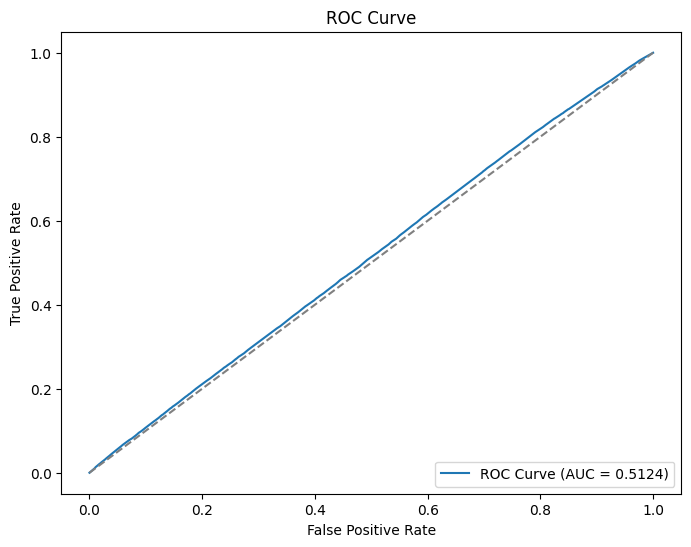


Top 20 Feature Importances:
                feature  importance
123        VOL_ADL_LT_y   67.735503
76          MA_EMA_MT_y    3.852675
101        MOM_ATR_MT_y    3.154985
70    RAW_prev_return_y    2.766261
74    MA_SMA_daily_LT_y    2.690274
84        OSC_MACD_MT_y    2.387126
91     OSC_STOCH_K_MT_y    1.860073
51       BOL_width_MT_x    1.456208
79         OSC_RSI_ST_y    1.435833
12          MA_EMA_LT_x    1.414520
32         OSC_MFI_ST_x    1.401083
94     OSC_STOCH_K_LT_y    1.204998
90   OSC_STOCH_RSI_ST_y    1.127756
104        MOM_ADX_MT_y    1.118386
63       TREND_CCI_MT_x    1.083940
42         MOM_ROC_MT_x    0.976518
65               open_y    0.956382
82        OSC_MACD_ST_y    0.805738
75          MA_EMA_ST_y    0.734013
28   OSC_STOCH_RSI_MT_x    0.635715


In [38]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, recall_score
# from sklearn.utils import resample, class_weight
# import matplotlib.pyplot as plt

# # ————————————— Prepare target —————————————
# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [c for c in df.columns if c not in ['date', 'target']]
# X = df[features]
# y = df['target']

# # ————————— Split train/test —————————
# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # ———————— Oversample the minority (class 1) ————————
# train_df = pd.concat([X_train, y_train.rename('target')], axis=1)
# pos = train_df[train_df['target'] == 1]
# neg = train_df[train_df['target'] == 0]

# # duplicate positives up to the same number as negatives
# pos_upsampled = resample(
#     pos,
#     replace=True,
#     n_samples=len(neg),
#     random_state=42
# )
# train_balanced = pd.concat([neg, pos_upsampled])
# X_train_bal = train_balanced[features]
# y_train_bal = train_balanced['target']

# # ————— Pools —————
# train_pool = Pool(X_train_bal, y_train_bal)
# test_pool  = Pool(X_test, y_test)

# # ————— Model with heavy weight on class 1, optimizing for Recall —————
# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.005,
#     depth=8,
#     loss_function='Logloss',
#     # use recall on the positive class for early stopping / best iteration
#     eval_metric='Precision',
#     # manually up‑weight the positive class even more
#     class_weights=[1, 3],
#     random_seed=42,
#     verbose=300,
#     od_type='Iter',
#     od_wait=150
# )

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=250,
#     verbose=300
# )

# # ————— Get predicted probabilities —————
# y_pred_proba = model.predict_proba(X_test)[:, 1]

# # ————— Find the threshold that gives you max recall (or a target recall) —————
# precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# # 1) absolute max recall happens at the *lowest* threshold → recall=1.0
# #    thr_maxrecall = pr_thresholds[0]

# # 2) or pick a target recall, e.g. 0.85
# target_recall = 0.85
# # find last index where recall ≥ target_recall
# idx = np.where(recall >= target_recall)[0][-1]
# optimal_threshold = pr_thresholds[idx]
# print(f"Threshold for recall ≥ {target_recall:.2f}: {optimal_threshold:.4f}")
# print(f"Precision at that point: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}")

# # ————— Apply threshold & report —————
# y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# print("\nClassification Report @ custom threshold:")
# print(classification_report(y_test, y_pred_adjusted))

# # ————— (Optional) ROC/AUC —————
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# print(f"\nTest AUC: {roc_auc:.4f}")

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# # ————— Feature importances —————
# feat_imp = model.get_feature_importance(train_pool)
# feat_imp_df = (
#     pd.DataFrame({'feature': features, 'importance': feat_imp})
#       .sort_values('importance', ascending=False)
# )
# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

Computed class weights: {0: 0.9319382739389356, 1: 1.0787864032520147}
0:	test: 0.5099170	best: 0.5099170 (0)	total: 308ms	remaining: 30m 48s
250:	test: 0.5203307	best: 0.5203308 (242)	total: 34s	remaining: 12m 58s
500:	test: 0.5214980	best: 0.5215351 (496)	total: 1m 4s	remaining: 11m 50s
750:	test: 0.5219926	best: 0.5220778 (707)	total: 1m 35s	remaining: 11m 6s
1000:	test: 0.5224511	best: 0.5224511 (1000)	total: 2m 5s	remaining: 10m 27s
1250:	test: 0.5231607	best: 0.5231607 (1250)	total: 2m 35s	remaining: 9m 48s
1500:	test: 0.5234622	best: 0.5234967 (1443)	total: 3m 4s	remaining: 9m 12s
1750:	test: 0.5238234	best: 0.5238274 (1736)	total: 3m 32s	remaining: 8m 35s
2000:	test: 0.5240635	best: 0.5240938 (1992)	total: 4m	remaining: 8m
2250:	test: 0.5244205	best: 0.5244352 (2233)	total: 4m 28s	remaining: 7m 26s
2500:	test: 0.5246101	best: 0.5246196 (2492)	total: 4m 56s	remaining: 6m 54s
2750:	test: 0.5248201	best: 0.5248436 (2723)	total: 5m 24s	remaining: 6m 23s
3000:	test: 0.5251185	best: 

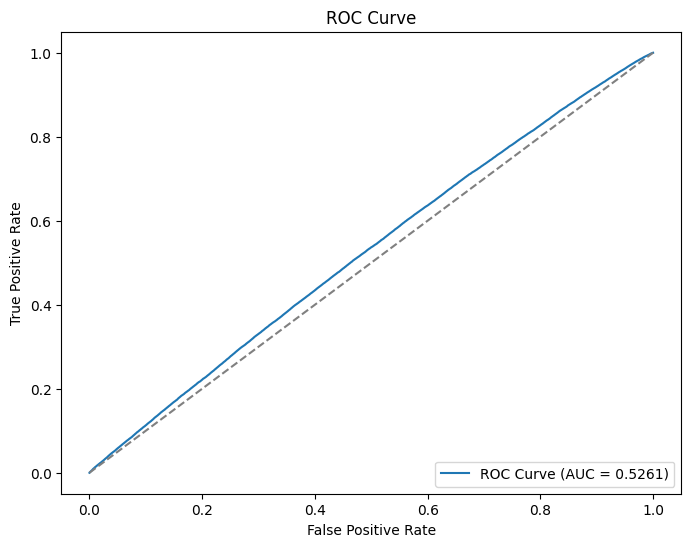

Selected threshold = 0.4147
→ Precision @ recall≥0.30: 0.4842
→ Recall    @ recall≥0.30: 0.3001


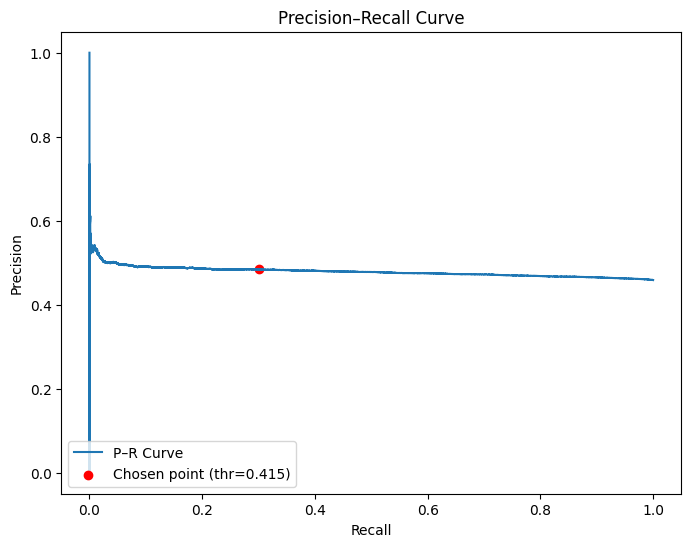


Classification Report @ strict threshold:
              precision    recall  f1-score   support

           0       0.55      0.73      0.63    106716
           1       0.48      0.30      0.37     90464

    accuracy                           0.53    197180
   macro avg       0.52      0.51      0.50    197180
weighted avg       0.52      0.53      0.51    197180


Top 20 Feature Importances:
                feature  importance
88     OSC_STOCH_K_ST_y    4.089856
5     RAW_prev_return_x    3.927369
70    RAW_prev_return_y    3.587558
23     OSC_STOCH_K_ST_x    3.574008
127      TREND_CCI_ST_y    2.355852
69             volume_y    2.142151
121        VOL_ADL_ST_y    2.036313
123        VOL_ADL_LT_y    2.010020
122        VOL_ADL_MT_y    1.722412
89     OSC_STOCH_D_ST_y    1.686550
62       TREND_CCI_ST_x    1.524336
91     OSC_STOCH_K_MT_y    1.468396
4              volume_x    1.382768
33         OSC_MFI_MT_x    1.287818
79         OSC_RSI_ST_y    1.197198
14         OSC_RSI_ST_x  

In [40]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# # --- prepare data ---
# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # --- compute balanced class weights ---
# classes = np.unique(y_train)
# weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
# class_weights = {int(c): w for c, w in zip(classes, weights)}
# print('Computed class weights:', class_weights)

# # --- train model ---
# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.008,
#     depth=8,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=250,
#     od_type='Iter',
#     od_wait=300,
#     class_weights=class_weights
# )

# train_pool = Pool(X_train, y_train)
# test_pool  = Pool(X_test, y_test)

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=200,
#     verbose=250
# )

# # --- baseline ROC AUC ---
# y_proba = model.predict_proba(X_test)[:, 1]
# fpr, tpr, roc_thresh = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
# print(f'Test ROC AUC: {roc_auc:.4f}')

# # Optional: plot ROC
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# # --- precision-recall curve & threshold selection ---
# precision, recall, pr_thresh = precision_recall_curve(y_test, y_proba)

# # enforce recall ≥ 30%
# mask = recall >= 0.30
# precision_masked = precision[mask]
# recall_masked    = recall[mask]
# thresh_masked    = pr_thresh[mask[:-1]]  # pr_thresh is one shorter than precision/recall

# best_idx = np.argmax(precision_masked)
# optimal_threshold = thresh_masked[best_idx]

# print(f"Selected threshold = {optimal_threshold:.4f}")
# print(f"→ Precision @ recall≥0.30: {precision_masked[best_idx]:.4f}")
# print(f"→ Recall    @ recall≥0.30: {recall_masked[best_idx]:.4f}")

# # Optional: plot Precision-Recall curve
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='P–R Curve')
# plt.scatter(recall_masked[best_idx], precision_masked[best_idx], color='red',
#             label=f"Chosen point (thr={optimal_threshold:.3f})")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision–Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

# # --- final predictions & report ---
# y_pred_strict = (y_proba >= optimal_threshold).astype(int)
# print("\nClassification Report @ strict threshold:")
# print(classification_report(y_test, y_pred_strict))

# # --- feature importances (optional) ---
# feat_imp = model.get_feature_importance(train_pool)
# feat_imp_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': feat_imp
# }).sort_values('importance', ascending=False)

# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

In [51]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# # --- prepare data ---
# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # --- compute balanced class weights, then upweight class 1 ---
# classes = np.unique(y_train)
# balanced_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
# class_weights = {int(c): w for c, w in zip(classes, balanced_weights)}

# # Increase the importance of class 1
# pos_weight_factor = 1.1
# class_weights[1] *= pos_weight_factor

# print('Adjusted class weights:', class_weights)

# # --- train model ---
# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.008,
#     depth=8,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=250,
#     od_type='Iter',
#     od_wait=300,
#     class_weights=class_weights
# )

# train_pool = Pool(X_train, y_train)
# test_pool  = Pool(X_test, y_test)

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=200,
#     verbose=250
# )

# # --- baseline ROC AUC ---
# y_proba = model.predict_proba(X_test)[:, 1]
# fpr, tpr, roc_thresh = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
# print(f'Test ROC AUC: {roc_auc:.4f}')

# # --- precision-recall curve & threshold selection ---
# precision, recall, pr_thresh = precision_recall_curve(y_test, y_proba)

# mask = recall >= 0.30
# precision_masked = precision[mask]
# recall_masked    = recall[mask]
# thresh_masked    = pr_thresh[mask[:-1]]  # pr_thresh is one element shorter

# best_idx = np.argmax(precision_masked)
# optimal_threshold = thresh_masked[best_idx]

# print(f"Selected threshold = {optimal_threshold:.4f}")
# print(f"→ Precision @ recall≥0.30: {precision_masked[best_idx]:.4f}")
# print(f"→ Recall    @ recall≥0.30: {recall_masked[best_idx]:.4f}")

# # --- final predictions & report ---
# y_pred_strict = (y_proba >= optimal_threshold).astype(int)
# print("\nClassification Report @ strict threshold:")
# print(classification_report(y_test, y_pred_strict))

# # --- feature importances ---
# feat_imp = model.get_feature_importance(train_pool)
# feat_imp_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': feat_imp
# }).sort_values('importance', ascending=False)

# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

Adjusted class weights: {0: 0.9319382739389356, 1: 1.1866650435772164}
0:	test: 0.5099171	best: 0.5099171 (0)	total: 161ms	remaining: 16m 6s
250:	test: 0.5202977	best: 0.5202977 (250)	total: 34.1s	remaining: 13m
500:	test: 0.5216392	best: 0.5216392 (500)	total: 1m 4s	remaining: 11m 44s
750:	test: 0.5220808	best: 0.5220814 (749)	total: 1m 33s	remaining: 10m 56s
1000:	test: 0.5226259	best: 0.5226321 (998)	total: 2m 5s	remaining: 10m 24s
1250:	test: 0.5230240	best: 0.5230274 (1123)	total: 2m 37s	remaining: 9m 57s
1500:	test: 0.5232214	best: 0.5232214 (1500)	total: 3m 7s	remaining: 9m 23s
1750:	test: 0.5234863	best: 0.5234973 (1724)	total: 3m 37s	remaining: 8m 47s
2000:	test: 0.5236921	best: 0.5236931 (1998)	total: 4m 5s	remaining: 8m 11s
2250:	test: 0.5239603	best: 0.5239603 (2250)	total: 4m 34s	remaining: 7m 37s
2500:	test: 0.5241757	best: 0.5241757 (2500)	total: 5m 4s	remaining: 7m 6s
2750:	test: 0.5243082	best: 0.5243106 (2696)	total: 5m 33s	remaining: 6m 33s
Stopped by overfitting det

In [42]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# # --- prepare data ---
# df['target'] = (df['close_y'].shift(-1) > df['close_y']).astype(int)
# df.dropna(inplace=True)

# features = [col for col in df.columns if col not in ['date', 'target']]
# X = df[features]
# y = df['target']

# train_size = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # --- compute balanced class weights, then upweight class 1 ---
# classes = np.unique(y_train)
# balanced_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
# class_weights = {int(c): w for c, w in zip(classes, balanced_weights)}

# # Increase the importance of class 1
# pos_weight_factor = 2.0
# class_weights[1] /= pos_weight_factor

# print('Adjusted class weights:', class_weights)

# # --- train model ---
# model = CatBoostClassifier(
#     iterations=6000,
#     learning_rate=0.008,
#     depth=8,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=250,
#     od_type='Iter',
#     od_wait=300,
#     class_weights=class_weights
# )

# train_pool = Pool(X_train, y_train)
# test_pool  = Pool(X_test, y_test)

# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     early_stopping_rounds=200,
#     verbose=250
# )

# # --- baseline ROC AUC ---
# y_proba = model.predict_proba(X_test)[:, 1]
# fpr, tpr, roc_thresh = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
# print(f'Test ROC AUC: {roc_auc:.4f}')

# # --- precision-recall curve & threshold selection ---
# precision, recall, pr_thresh = precision_recall_curve(y_test, y_proba)

# # enforce recall ≥ 30%
# mask = recall >= 0.30
# precision_masked = precision[mask]
# recall_masked    = recall[mask]
# thresh_masked    = pr_thresh[mask[:-1]]  # pr_thresh is one element shorter

# best_idx = np.argmax(precision_masked)
# optimal_threshold = thresh_masked[best_idx]

# print(f"Selected threshold = {optimal_threshold:.4f}")
# print(f"→ Precision @ recall≥0.30: {precision_masked[best_idddx]:.4f}")
# print(f"→ Recall    @ recall≥0.30: {recall_masked[best_idx]:.4f}")

# # --- final predictions & report ---
# y_pred_strict = (y_proba >= optimal_threshold).astype(int)
# print("\nClassification Report @ strict threshold:")
# print(classification_report(y_test, y_pred_strict))

# # --- feature importances ---
# feat_imp = model.get_feature_importance(train_pool)
# feat_imp_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': feat_imp
# }).sort_values('importance', ascending=False)

# print("\nTop 20 Feature Importances:")
# print(feat_imp_df.head(20))

Adjusted class weights: {0: 0.9319382739389356, 1: 0.5393932016260073}
0:	test: 0.5159319	best: 0.5159319 (0)	total: 152ms	remaining: 15m 14s
250:	test: 0.5220417	best: 0.5220485 (248)	total: 34.2s	remaining: 13m 2s
500:	test: 0.5228589	best: 0.5228698 (493)	total: 1m 5s	remaining: 11m 58s
750:	test: 0.5233328	best: 0.5233355 (748)	total: 1m 34s	remaining: 11m 1s
1000:	test: 0.5237266	best: 0.5237268 (999)	total: 2m 4s	remaining: 10m 23s
1250:	test: 0.5241091	best: 0.5241091 (1250)	total: 2m 34s	remaining: 9m 48s
1500:	test: 0.5245440	best: 0.5245545 (1491)	total: 3m 3s	remaining: 9m 11s
1750:	test: 0.5248935	best: 0.5248974 (1748)	total: 3m 33s	remaining: 8m 38s
2000:	test: 0.5252482	best: 0.5252641 (1992)	total: 4m 1s	remaining: 8m 3s
2250:	test: 0.5254899	best: 0.5254983 (2239)	total: 4m 30s	remaining: 7m 30s
2500:	test: 0.5258388	best: 0.5258468 (2481)	total: 4m 59s	remaining: 6m 59s
2750:	test: 0.5259245	best: 0.5259468 (2660)	total: 5m 28s	remaining: 6m 27s
3000:	test: 0.5262287	